# Northwind Trades ® - Enhancing Product Recommendations and Warehouse Efficiency through Data-Driven Analytics
## Part 4: Product Recommendation by Cosine Similarity

### Intuition

The recommendation engine is designed to suggest products to customers based on their purchase history and the purchase history of similar customers. The engine derives `SIMILARITY` undirected relationships between customers based on the common products they have purchased. The similarity score is calculated using cosine similarity, which measures the cosine of the angle between two non-zero vectors in an inner product space. The closer the cosine similarity score is to 1, the more similar the two customers are.

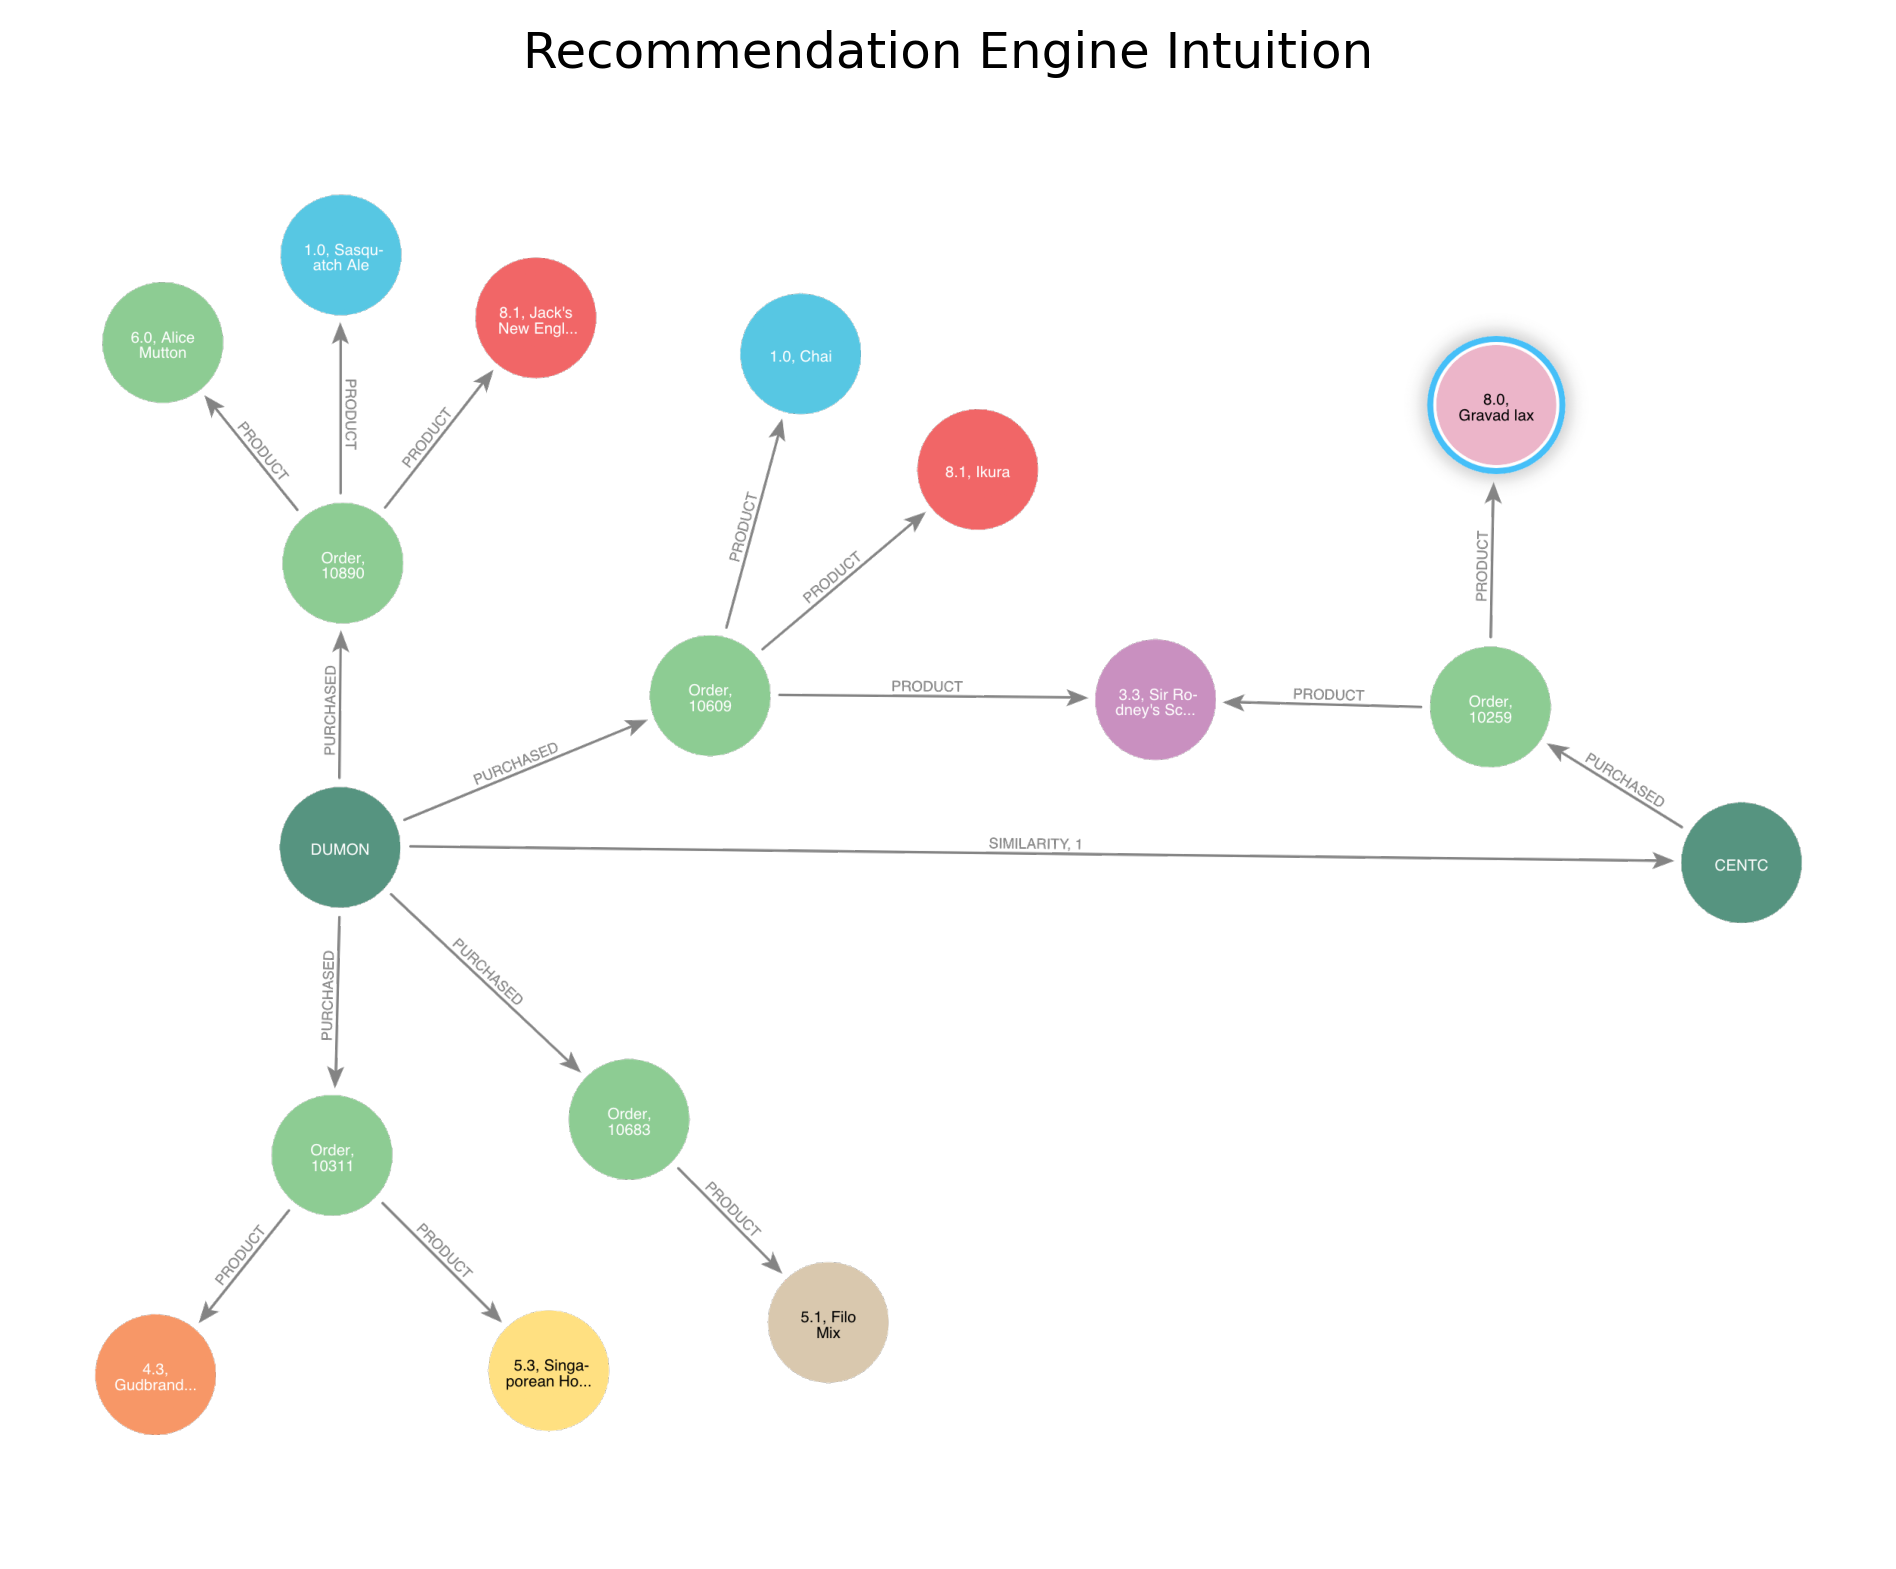

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def show_image(image_path: str, title: str, dpi: int = 300) -> None:
    img = mpimg.imread(image_path)
    plt.figure(dpi=dpi, figsize=(img.shape[1] / dpi, img.shape[0] / dpi))
    plt.title(title)

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Remove the axis (borders)
    plt.axis('off')

    plt.imshow(img)
    plt.show()


show_image("images/recommendation.png", "Recommendation Engine Intuition", dpi=300)

### Included Modules, Packages, and Supporting Functions

In [2]:
import getpass
import platform

import pandas as pd
from neo4j import Session, Driver, GraphDatabase


def generate_neo4j_local_driver() -> Driver:
    if platform.system() == "Darwin" and getpass.getuser() == "honghu":
        return GraphDatabase.driver(uri="bolt://localhost:7689", auth=("neo4j", "ucb_mids_w205"))
    else:
        return GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))


def generate_neo4j_local_session(driver: Driver, database: str = "neo4j") -> Session:
    return driver.session(database=database)

def my_neo4j_run_query_pandas(query: str, session: Session, **kwargs) -> pd.DataFrame:
    """
    Run a query and return the results in a pandas DataFrame.

    :param query: The Cypher query to be executed.
    :param session: The Neo4j session to use for running the query.
    :param kwargs: Additional parameters to pass to the session.run() method.
    :return: A pandas DataFrame containing the query results.
    """
    result = session.run(query, **kwargs)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

driver = generate_neo4j_local_driver()
neo4j_session = generate_neo4j_local_session(driver)

### Derive Directed `RATED` Edges between Customers and Products

To recommend product for users, we need to know how favorably a user rated a product. We will use the `RATED` edge to represent this relationship. The edges for between customers and products are created by the times the customer purchased the product divided by total orders by the customer. The more times a customer purchased a product, the more likely they are to recommend it. The more orders a customer has, the more likely they rate the product. 

In [3]:
cypher_exec = """
MATCH (c:Customer)-[:PURCHASED]->(o:Order)-[:PRODUCT]->(p:Product)
WITH c, count(p) AS total
MATCH (c)-[:PURCHASED]->(o:Order)-[:PRODUCT]->(p:Product)
WITH c, total, p, count(o) * 1.0 AS orders
MERGE (c)-[rated:RATED]->(p)
  ON CREATE SET rated.rating = orders / total, rated.formatted_rating = ROUND((orders / total) * 100) / 100.0
  ON MATCH SET rated.rating = orders / total, rated.formatted_rating = ROUND((orders / total) * 100) / 100.0
;
"""
neo4j_session.run(cypher_exec)

params_template = {
    "is_two_way": False,
    "beg_node_label": "Customer",
    "end_node_label": "Product",
    "edge_name": "RATED",
    "edge_weight": "rating"
}
cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']}) 
RETURN n1.id as customer_id, r.{params_template['edge_weight']} as rating, n2.product_name as product_name
ORDER BY r.{params_template['edge_weight']} DESC
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,customer_id,rating,product_name
0,LAZYK,0.500000,Queso Cabrales
1,CENTC,0.500000,Sir Rodney's Scones
2,CENTC,0.500000,Gravad lax
3,LAZYK,0.500000,Boston Crab Meat
4,NORTS,0.333333,Outback Lager
...,...,...,...
1680,SAVEA,0.008621,Ravioli Angelo
1681,SAVEA,0.008621,Escargots de Bourgogne
1682,SAVEA,0.008621,Sirop d'érable
1683,SAVEA,0.008621,Vegie-spread


### Rating Example

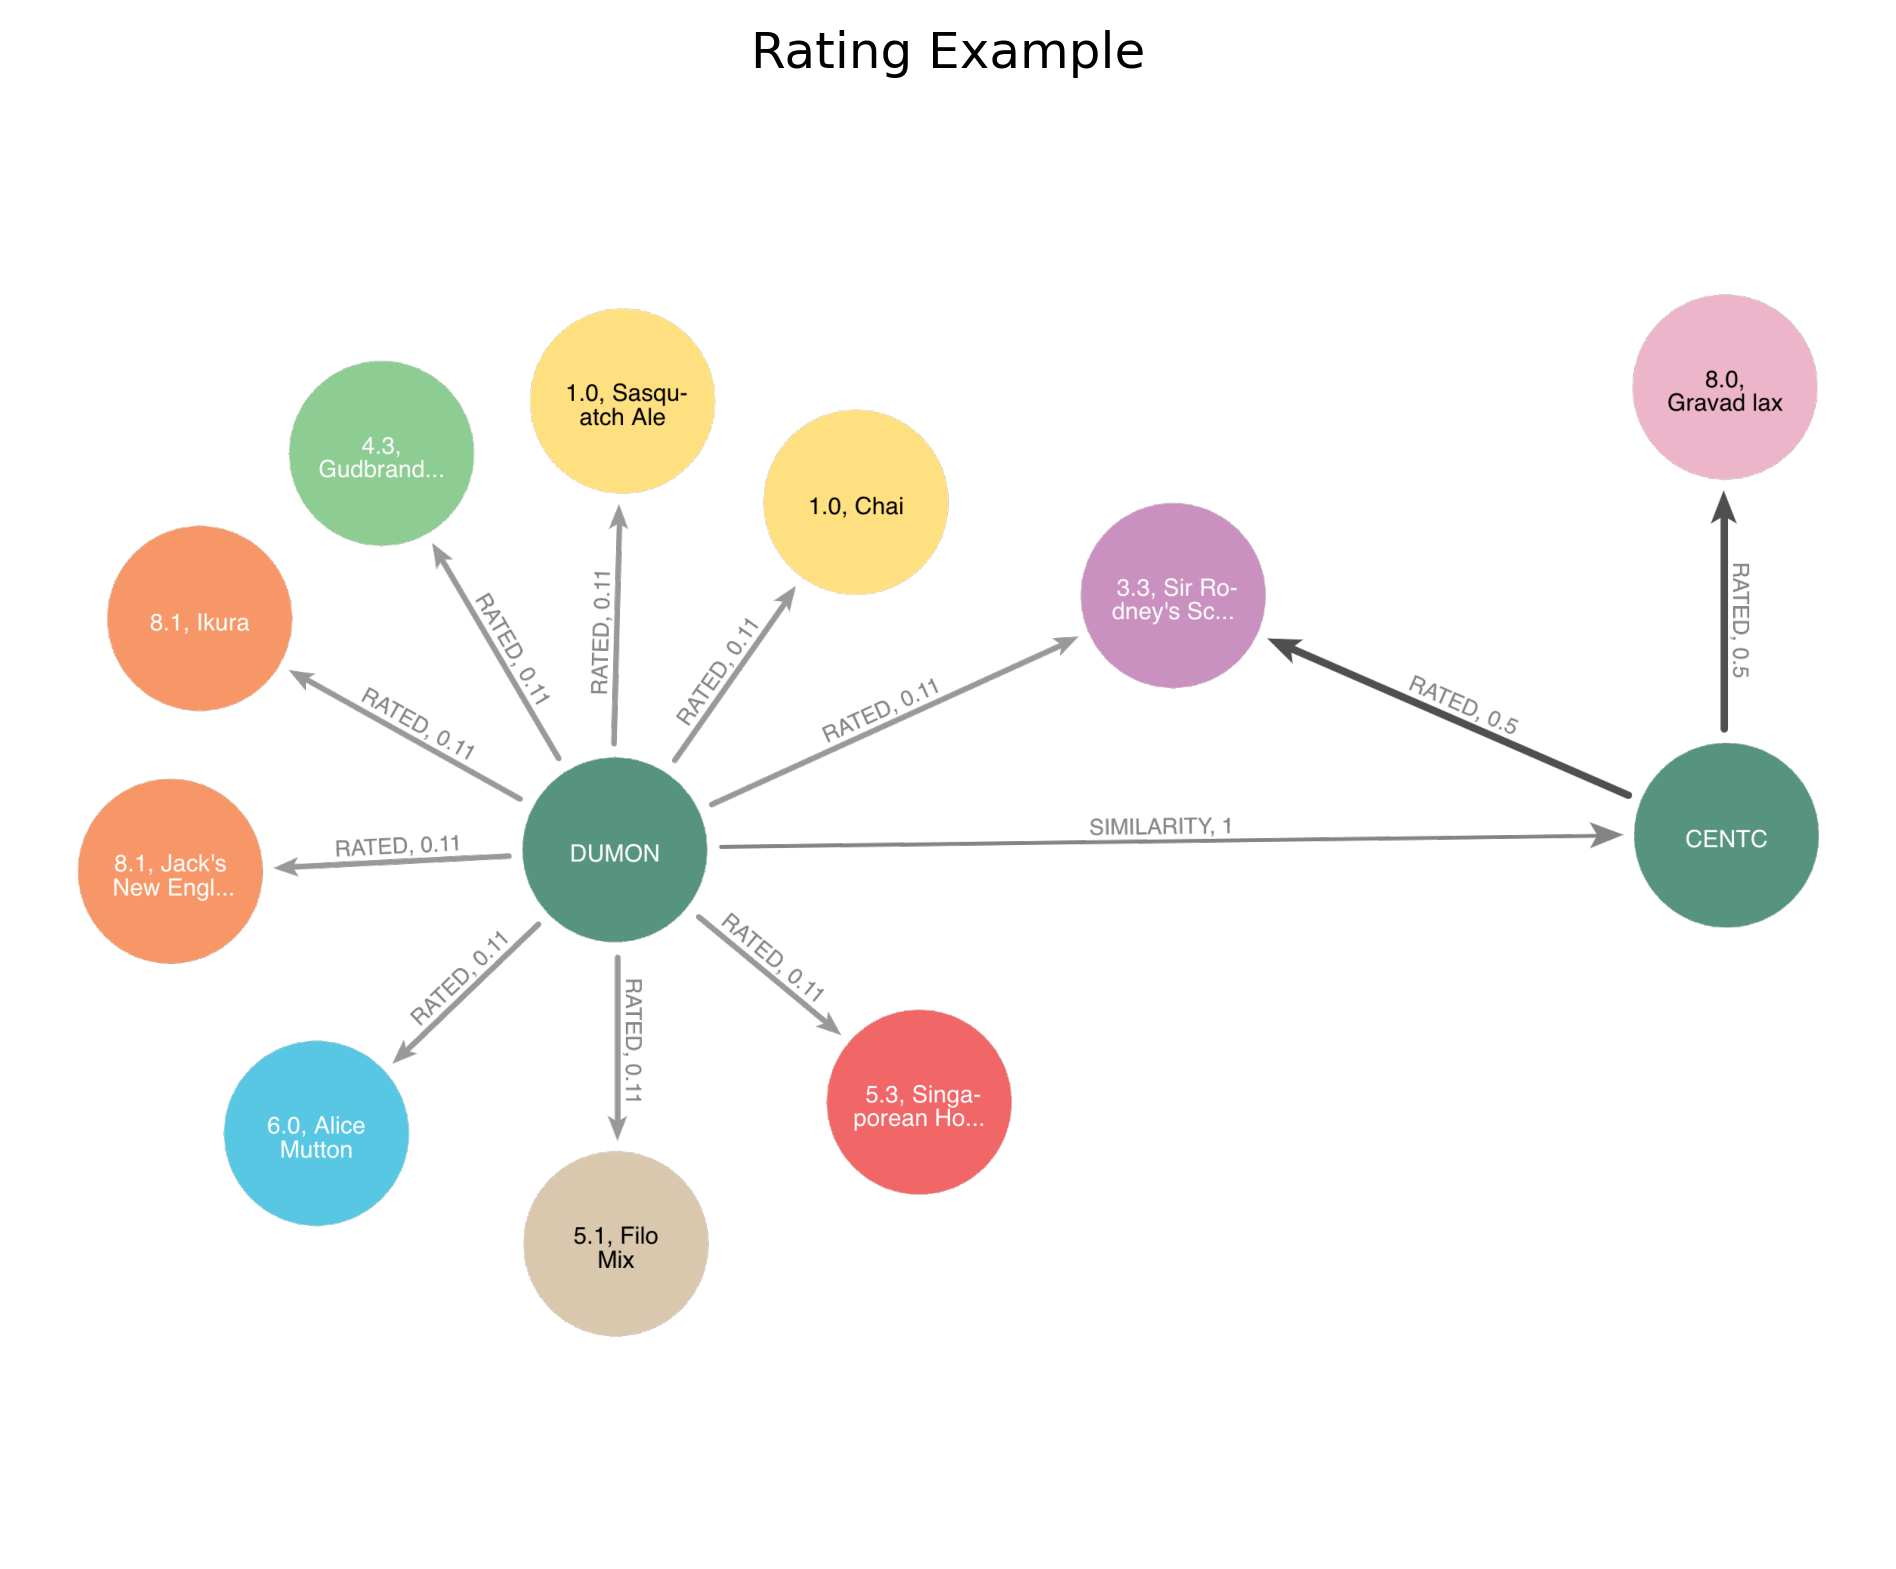

In [4]:
show_image("images/rating_example.png", "Rating Example", dpi=300)

### Derive Undirected `SIMILARITY` Edges between Customers and Customers using Cosine Similarity

If customer A and customer B have purchased same product 1 and product 2, we will calculate the similarity based on the rating vector of the two products by customer A and customer B using cosine similarity. The higher the similarity score, the more likely they are similar to each other.

In [5]:
min_common_products = 1

cypher_exec = f"""
MATCH (c1:Customer)-[r1:RATED]->(p:Product)<-[r2:RATED]-(c2:Customer)
WITH c1, c2, r1, r2, COLLECT(p) AS commonProducts
  WHERE SIZE(commonProducts) >= {min_common_products}
WITH
  sum(r1.rating * r2.rating) AS dot_product,
  sqrt(reduce(x = 0.0, a IN collect(r1.rating) | x + a ^ 2)) AS r1_length,
  sqrt(reduce(y = 0.0, b IN collect(r2.rating) | y + b ^ 2)) AS r2_length,
  c1, c2
MERGE (c1)-[s:SIMILARITY]-(c2)
  ON CREATE SET s.similarity = dot_product / (r1_length * r2_length)
  ON MATCH SET s.similarity = dot_product / (r1_length * r2_length)
;
"""
neo4j_session.run(cypher_exec)

params_template = {
    "is_two_way": True,
    "beg_node_label": "Customer",
    "end_node_label": "Customer",
    "edge_name": "SIMILARITY",
    "edge_weight": "similarity"
}
cypher_query = f"""
MATCH (n1:{params_template['beg_node_label']})-[r:{params_template['edge_name']}]-{'' if params_template['is_two_way'] else '>'}(n2:{params_template['end_node_label']}) 
RETURN n1.id as one_customer_id, r.{params_template['edge_weight']} as similarity, n2.id as other_customer_id
ORDER BY r.{params_template['edge_weight']} DESC
"""
my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

,one_customer_id,similarity,other_customer_id
0,LEHMS,1.000000,WELLI
1,TORTU,1.000000,TRADH
2,TRADH,1.000000,TORTU
3,WELLI,1.000000,LEHMS
4,ALFKI,1.000000,TRADH
...,...,...,...
7229,WARTH,0.693375,TOMSP
7230,CHOPS,0.670820,FOLKO
7231,FOLKO,0.670820,CHOPS
7232,HUNGO,0.650987,VAFFE


### Recommendation in Action

In [6]:
def recommend_products(customer_id: str, max_recommendation: int = 3) -> pd.DataFrame:
    cypher_query = f"""
MATCH (me:Customer)-[s:SIMILARITY]->(c:Customer)-[r:RATED]->(p:Product)
WHERE NOT ((me)-[:RATED]->(p:Product)) AND me.id = '{customer_id}'
RETURN me.company_name as to_recommended, c.company_name as recommended_based_on, s.similarity as similarity, r.rating as rating, p.product_name as recommended_product_name
ORDER BY s.similarity * r.rating DESC
LIMIT {max_recommendation}
    """
    return my_neo4j_run_query_pandas(cypher_query, session=neo4j_session)

customer_id = "DUMON"
recommend_products(customer_id, 1)

,to_recommended,recommended_based_on,similarity,rating,recommended_product_name
0,Du monde entier,North/South,1.0,0.333333,Outback Lager
